In [4]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [5]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # add dimenstion of feature for torch module
t_u = torch.tensor(t_u).unsqueeze(1) 

t_u.shape

torch.Size([11, 1])

In [6]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 5, 10,  6,  4,  7,  1,  3,  0,  2]), tensor([9, 8]))

In [7]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [31]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # linear_model is instance of nn.Linear()
# Linear's arg is input features and output features. in this case, both of them are temperature(F and C) 
linear_model(t_un_val) # there's two obervation input, thus two output(predicted by model)

tensor([[-4.7996],
        [-3.8044]], grad_fn=<AddmmBackward0>)

In [33]:
linear_model.weight, linear_model.bias # only one W and B

(Parameter containing:
 tensor([[-0.8293]], requires_grad=True),
 Parameter containing:
 tensor([0.2096], requires_grad=True))

In [34]:
x = torch.ones(1) # pytorch automatically dealt the unusual input dimension
linear_model(x)

tensor([-0.6198], grad_fn=<AddBackward0>)

In [35]:
x = torch.ones(10, 1) # there's ten samples containing one feature. Usually 0 index is the sample number of single batch.
linear_model(x)

tensor([[-0.6198],
        [-0.6198],
        [-0.6198],
        [-0.6198],
        [-0.6198],
        [-0.6198],
        [-0.6198],
        [-0.6198],
        [-0.6198],
        [-0.6198]], grad_fn=<AddmmBackward0>)

In [13]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(
    linear_model.parameters(), # <2>
    lr=1e-2)

In [36]:
linear_model.parameters(), list(linear_model.parameters()) # call as list 

(<generator object Module.parameters at 0x7fe9501e0cf0>,
 [Parameter containing:
  tensor([[-0.8293]], requires_grad=True),
  Parameter containing:
  tensor([0.2096], requires_grad=True)])

In [16]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad() # optimizer already know what params needs to be updated
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [17]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 354.1807, Validation loss 220.7539
Epoch 1000, Training loss 2.5463, Validation loss 9.5217
Epoch 2000, Training loss 2.0061, Validation loss 8.8163
Epoch 3000, Training loss 1.9966, Validation loss 8.7308

Parameter containing:
tensor([[5.4039]], requires_grad=True)
Parameter containing:
tensor([-16.9539], requires_grad=True)


In [18]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # here you can input ready-made loss function of torch or custome loss function
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 213.0342, Validation loss 104.9498
Epoch 1000, Training loss 2.6110, Validation loss 9.5719
Epoch 2000, Training loss 2.0072, Validation loss 8.8220
Epoch 3000, Training loss 1.9966, Validation loss 8.7315

Parameter containing:
tensor([[5.4035]], requires_grad=True)
Parameter containing:
tensor([-16.9516], requires_grad=True)


In [37]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [20]:
[param.shape for param in seq_model.parameters()] # W and B in each layer

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [21]:
for name, param in seq_model.named_parameters():
    print(name, param.shape) # you can call the name of params, 

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [22]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([ # Ordered Dictionary is differ from Dictionary of python. 
    ('hidden_linear', nn.Linear(1, 8)), # ordinary dictionary of python has no order. 
    ('hidden_activation', nn.Tanh()), # you can define the name of each layer using OrderedDict function.
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [23]:
for name, param in seq_model.named_parameters():
    print(name, param.shape) # you can check the name you typed in.

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [24]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.1038], requires_grad=True)

In [25]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 211.1098, Validation loss 106.7278
Epoch 1000, Training loss 3.8351, Validation loss 8.9248
Epoch 2000, Training loss 2.7536, Validation loss 2.4038
Epoch 3000, Training loss 1.8051, Validation loss 3.1836
Epoch 4000, Training loss 1.5286, Validation loss 3.6362
Epoch 5000, Training loss 1.4086, Validation loss 4.0678
output tensor([[16.1813],
        [ 8.2814]], grad_fn=<AddmmBackward0>)
answer tensor([[13.],
        [ 6.]])
hidden tensor([[ -0.9855],
        [  0.2686],
        [-11.1527],
        [  0.3373],
        [  0.3325],
        [  7.4681],
        [  9.0865],
        [ 11.2581]])


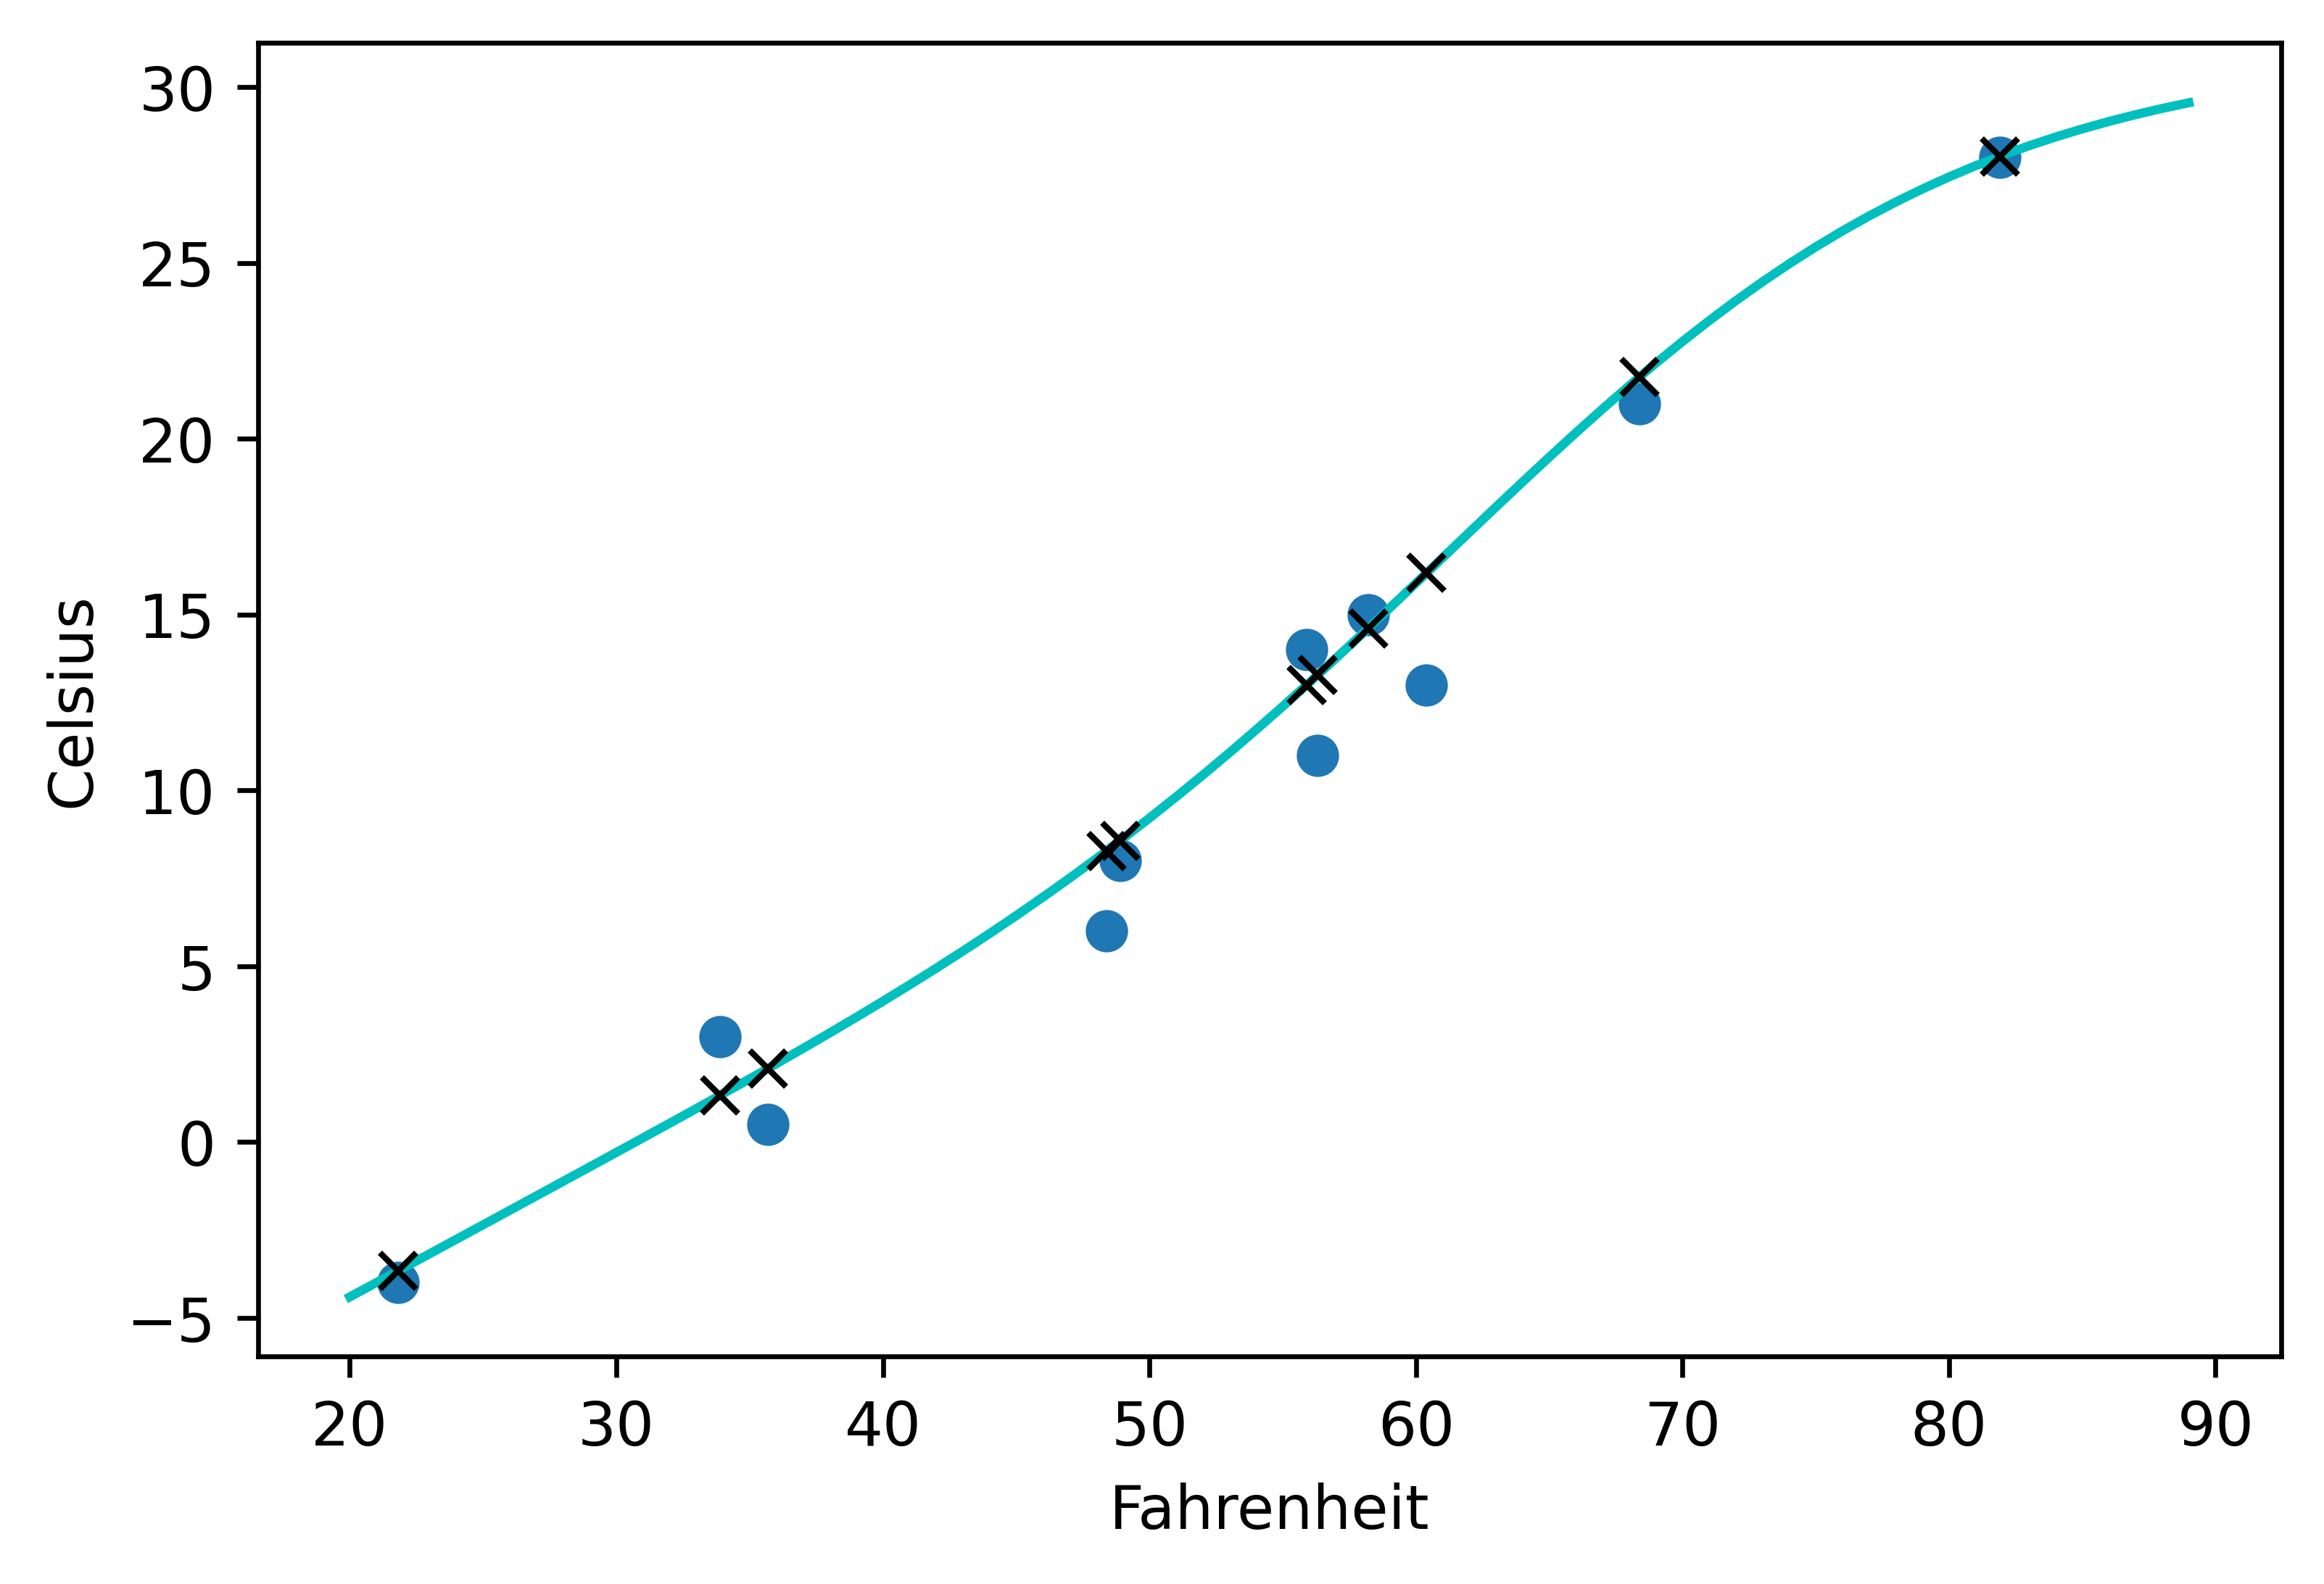

In [26]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


Epoch 1, Training loss 205.6097, Validation loss 101.7912
Epoch 1000, Training loss 48.6437, Validation loss 9.9507
Epoch 2000, Training loss 24.8340, Validation loss 10.8570
Epoch 3000, Training loss 11.9470, Validation loss 11.1925
Epoch 4000, Training loss 7.1200, Validation loss 11.7088
Epoch 5000, Training loss 5.4149, Validation loss 11.7589


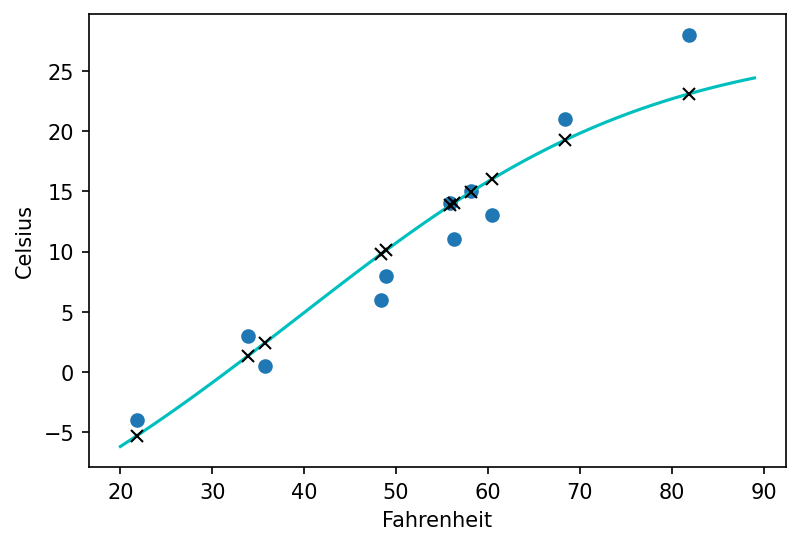

In [27]:
# Exercises here!

neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
